In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import torch.optim as optim
# Custom Data Loader pwd is ../Custom_Data_loader.py
from Custom_Data_loader import CustomDataset
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import numpy as np


In [2]:
# Extract the processed data and labels
import os

transform = transforms.Compose([
    transforms.Resize((120, 160)),
    transforms.ToTensor(),
])

root_path_dir = 'Sample_Data/training_validation_data'
image_paths = []
annot_paths = []

i = 0

for level in os.listdir(root_path_dir):
    level_dir = root_path_dir + '/' + level
    normal_dir = level_dir + '/' + os.listdir(level_dir)[1]
    hitbox_dir = level_dir + '/' + os.listdir(level_dir)[0]
    for image in os.listdir(normal_dir):
        # print(image)
        image_path = normal_dir + '/' + image
        image_paths.append(image_path)
        i += 1
    for annot in os.listdir(hitbox_dir):
        annot_path = hitbox_dir + '/' + annot
        annot_paths.append(annot_path)

print("Total images: ", i)

dataset = CustomDataset(image_paths=image_paths,
                        annot_paths=annot_paths,
                        transform=transform)

# Split the dataset 

train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

print("Train size: ", train_size, "Validation size: ", val_size, "Test size: ", test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Test the dataset and DataLoader
# a_img = Image.open('Sample_Data/polargeist/polargeist_hitbox/1.png').convert("RGB")
# to_tensor_transform = transforms.ToTensor()
# a_img = to_tensor_transform(a_img) * 255.0
# f = dataset.create_multi_masks(a_img)
# CustomDataset.plot_multi_mask(f)

for images, masks in train_loader:
    print("Train batch - Images:", images.shape, "Masks:", masks.shape)
    break  # Just to check one batch, remove break to iterate through all batches

for images, masks in val_loader:
    print("Validation batch - Images:", images.shape, "Masks:", masks.shape)
    break  # Just to check one batch, remove break to iterate through all batches

for images, masks in test_loader:
    print("Test batch - Images:", images.shape, "Masks:", masks.shape)
    break  # Just to check one batch, remove break to iterate through all batches




Total images:  1543
Train size:  1080 Validation size:  231 Test size:  232
Train batch - Images: torch.Size([32, 3, 120, 160]) Masks: torch.Size([32, 11, 120, 160])
Validation batch - Images: torch.Size([32, 3, 120, 160]) Masks: torch.Size([32, 11, 120, 160])
Test batch - Images: torch.Size([32, 3, 120, 160]) Masks: torch.Size([32, 11, 120, 160])


In [41]:
def balance_class_weights(data, num_classes):
    # Get the number of classes
    class_count = torch.zeros(num_classes)
    for _, label in data:
        for i in range(label.shape[0]):
            class_count[i] += (label[i] == 1).sum().item()

    # print(class_count)

    # Get the class weights
    class_weights = torch.zeros(num_classes)
    class_weights = class_count.sum() / (num_classes * class_count)

    return class_weights

In [43]:
class_weights = balance_class_weights(train_dataset, 11)

tensor([ 4867258.,   362136.,    71933.,    33229.,    16239.,   108223.,
          245219.,    15412.,   207347.,   170303., 15294170.])


In [3]:
###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [4]:
class BaseCNN(nn.Module):
    def __init__(self, n_classes):
        super(BaseCNN, self).__init__()
        self.name = "BaseCNN"
        
# Encoder part with only two convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Decoder part with a single upsampling and convolution
        self.upconv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv2(x))
        
        # Decoder
        x = self.upsample(x)
        x = F.relu(self.upconv1(x))
        x = self.final_conv(x)
        
        return x

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super(SimpleCNN, self).__init__()
        self.name = "SimpleCNN"
        
        # Encoder part
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Decoder part (no skip connections)
        self.upconv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv4(x))
        
        # Decoder (no skip connections)
        x = self.upsample(x)
        x = F.relu(self.upconv1(x))
        
        x = self.upsample(x)
        x = F.relu(self.upconv2(x))
        
        x = self.upsample(x)
        x = F.relu(self.upconv3(x))
        x = self.final_conv(x)
        
        return x

In [6]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    ) 

class GDMapUNet(nn.Module):
    def __init__(self, n_classes):
        super(GDMapUNet, self).__init__()
        self.name = "GDMapUNet"
        self.downconv1 = double_conv(3, 64)
        self.downconv2 = double_conv(64, 128)
        self.downconv3 = double_conv(128, 256)
        self.downconv4 = double_conv(256, 512) 

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)     

        self.upconv1 = double_conv(256 + 512, 256)
        self.upconv2 = double_conv(128 + 256, 128)
        self.upconv3 = double_conv(128 + 64, 64)
        self.upconvSMAP = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        conv1 = self.downconv1(x)
        x = self.maxpool(conv1)

        conv2 = self.downconv2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.downconv3(x)
        x = self.maxpool(conv3)   
        
        x = self.downconv4(x)
        
        # feed in information from the encoder using concat skip connections

        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.upconv1(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.upconv2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)  
        x = self.upconvSMAP(self.upconv3(x))
        
        return x


In [7]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "GD_model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [8]:
import numpy as np

# Values we want to keep constant throughout the project


imshape_ = (3, 120, 160)
            # Class names:      # Class color  # Channel Number in target matrix
class_colors_ = {'platform':     (000,000,187), # 0
               'spike':          (127,000,000), # 1
               'player':         (255,255,255), # 2
               'yellow jump orb':(255,255,68), # 3
               'blue jump orb':  (17,255,255), # 4
               'blue pad':       (7,102,102), # 5
               'yellow pad':     (102,102,27), # 6
               'pink jump orb':  (255,119,255), #7
               'pink pad':       (102,48,102), #8
               'portal':         (17, 170, 0), #9
               'background':     (000,000,000)  # 10 # Not needed as it is the default value
}

labels_ = class_colors_.keys()
n_classes_ = len(class_colors_) # +1 for background class

batch_size_ = 32    

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels




In [55]:
#PyTorch
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # print(inputs, inputs.shape)
        # print(targets, targets.shape)
        
        #True Positives, False Positives & False Negatives

        if self.weight is not None:
            weights = self.weight[targets.long()]
            inputs = inputs * weights

        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [18]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        total_err += accuracy(outputs, labels)
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def get_pred(outputs):
    outputs = F.softmax(outputs, dim=1)
    max_vals, _ = torch.max(outputs, dim=1, keepdim=True)
    pred = (outputs == max_vals).float()
    return pred

def accuracy(outputs, label):
    outputs = F.softmax(outputs, dim=1)
    max_vals, _ = torch.max(outputs, dim=1, keepdim=True)
    pred = (outputs == max_vals).float()
    diff = pred - label
    acc = torch.sum(diff == 0).item() / pred.numel()
    return acc

def model_accuracy(model, data):
    model.eval()
    correct = 0
    total = 0
    for i, data in enumerate(data, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = model(inputs)
        max_vals, _ = torch.max(pred, dim=1, keepdim=True)
        pred = (pred == max_vals).float()
        correct += accuracy(outputs, labels)
        total += 1
    return correct / total

In [56]:
import time
def train_net(net, batch_size=4, learning_rate=0.01, num_epochs=30, checkpoint_interval=1):
    ########################################################################
    # Train a classifier on geodash data.
    torch.manual_seed(1000)
    criterion = FocalTverskyLoss(weight=class_weights)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    # Set up some numpy arrays to store the training/test loss/err
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    start_time = time.time()

    inputs, labels = next(iter(train_loader))
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            total_train_err += accuracy(outputs, labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)
            

        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")

        save_folder = "saved_models"

        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        if epoch % checkpoint_interval == 0 or epoch == num_epochs - 1:
            model_path = save_folder + '/' + get_model_name(net.name, batch_size, learning_rate, epoch)
            print(f"Saving model to {model_path}")
            torch.save(net.state_dict(), model_path)

        print('Finished Training')
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Total time elapsed: {elapsed_time:.2f} seconds")

        # Write the train/test loss/err into CSV files for plotting later
        epochs = np.arange(1, num_epochs + 1)
        np.savetxt(model_path + "_train_err.csv", train_err)
        np.savetxt(model_path + "_train_loss.csv", train_loss)
        np.savetxt(model_path + "_val_err.csv", val_err)
        np.savetxt(model_path + "_val_loss.csv", val_loss)

In [11]:
!nvidia-smi

Wed Aug 14 20:12:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.30                 Driver Version: 546.30       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P3              21W / 100W |    808MiB /  8192MiB |     43%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
if torch.cuda.is_available():
    print("CUDA is available. PyTorch will use the GPU.")
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch will use the GPU.


In [13]:
print(torch.__version__)

2.0.1+cu117


In [58]:
UNetMODELv1 = GDMapUNet(n_classes_)
train_net(UNetMODELv1, batch_size=batch_size_, learning_rate=0.01, num_epochs=30, checkpoint_interval=1)

Epoch 1: Train err: 0.028045355126423376, Train loss: 0.006964180399389828 | Validation err: 0.03279454840540728, Validation loss: -0.04426887631416321
Saving model to saved_models/GD_model_GDMapUNet_bs32_lr0.01_epoch0
Finished Training
Total time elapsed: 221.73 seconds
Epoch 2: Train err: 0.029888622964672765, Train loss: -0.09006586144952212 | Validation err: 0.03279454840540728, Validation loss: -0.13930101692676544
Saving model to saved_models/GD_model_GDMapUNet_bs32_lr0.01_epoch1
Finished Training
Total time elapsed: 446.62 seconds
Epoch 3: Train err: 0.029888613602752058, Train loss: -0.22926408753675573 | Validation err: 0.03279454840540728, Validation loss: -0.3835722655057907
Saving model to saved_models/GD_model_GDMapUNet_bs32_lr0.01_epoch2
Finished Training
Total time elapsed: 667.93 seconds
Epoch 4: Train err: 0.029889740275658792, Train loss: -0.5254753687802483 | Validation err: 0.03279454840540728, Validation loss: -0.5638102144002914
Saving model to saved_models/GD_mod

In [ ]:
UNetMODELv2 = GDMapUNet(n_classes_)
train_net(UNetMODELv2, batch_size=batch_size_, learning_rate=0.001, num_epochs=30, checkpoint_interval=1)

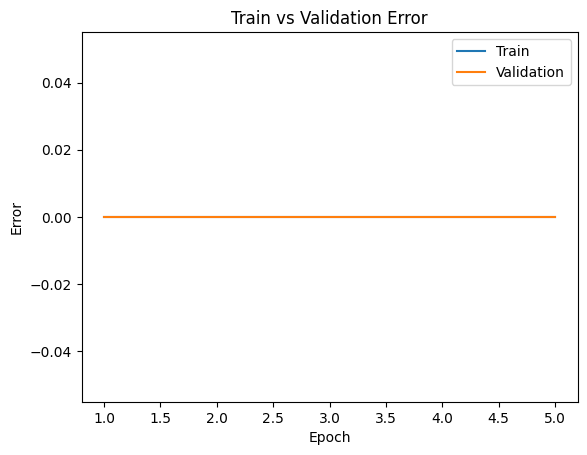

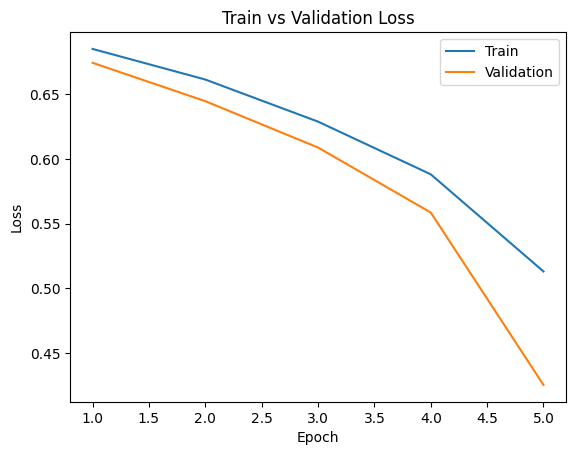

In [ ]:
plot_training_curve("GD_model_GDMapUNet_bs32_lr0.01_epoch4")

In [ ]:
simpleMODELv1 = SimpleCNN(n_classes_)
train_net(simpleMODELv1, batch_size=batch_size_, learning_rate=0.01, num_epochs=30, checkpoint_interval=1)

Epoch 1: Train err: 0.0, Train loss: 0.6721108678509208 | Validation err: 0.0, Validation loss: 0.6329604536294937
Saving model to GD_model_SimpleCNN_bs32_lr0.01_epoch0
Finished Training
Total time elapsed: 114.42 seconds
Epoch 2: Train err: 0.0, Train loss: 0.5930050331003526 | Validation err: 0.0, Validation loss: 0.5493691265583038
Saving model to GD_model_SimpleCNN_bs32_lr0.01_epoch1
Finished Training
Total time elapsed: 230.07 seconds


KeyboardInterrupt: 

In [ ]:
simpleMODELv2 = SimpleCNN(n_classes_)
train_net(simpleMODELv2, batch_size=batch_size_, learning_rate=0.001, num_epochs=30, checkpoint_interval=1)

In [ ]:
BaseMODEL = BaseCNN(n_classes_)
train_net(BaseMODEL, batch_size=batch_size_, learning_rate=0.01, num_epochs=30, checkpoint_interval=1)

Epoch 1: Train err: 0.029762643570762602, Train loss: 0.6471791319987353 | Validation err: 0.03279454840540728, Validation loss: 0.36123349517583847
Saving model to saved_models/GD_model_BaseCNN_bs32_lr0.1_epoch0
Finished Training
Total time elapsed: 59.00 seconds
Epoch 2: Train err: 0.029888622964672765, Train loss: 0.3585548418409684 | Validation err: 0.03279454840540728, Validation loss: 0.3611895442008972
Saving model to saved_models/GD_model_BaseCNN_bs32_lr0.1_epoch1
Finished Training
Total time elapsed: 329.68 seconds


KeyboardInterrupt: 

In [52]:
from Custom_Data_loader import CustomDataset

TESTING:  12 (11, 120, 160)


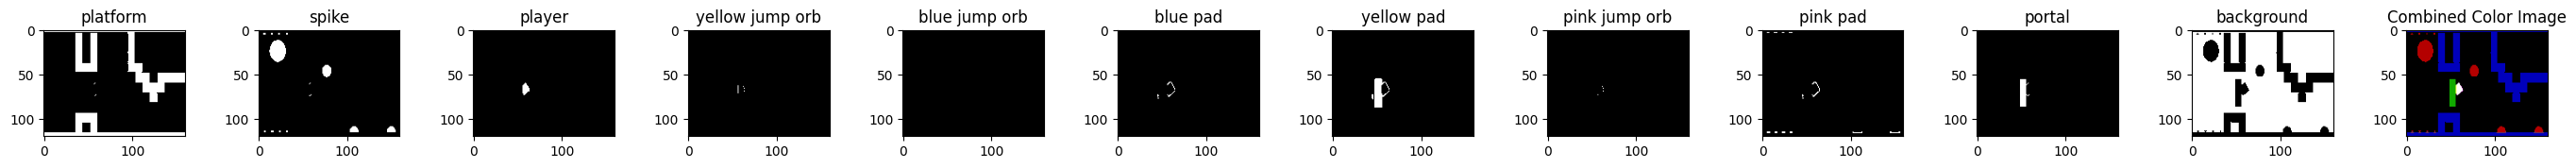

TESTING:  12 (11, 120, 160)


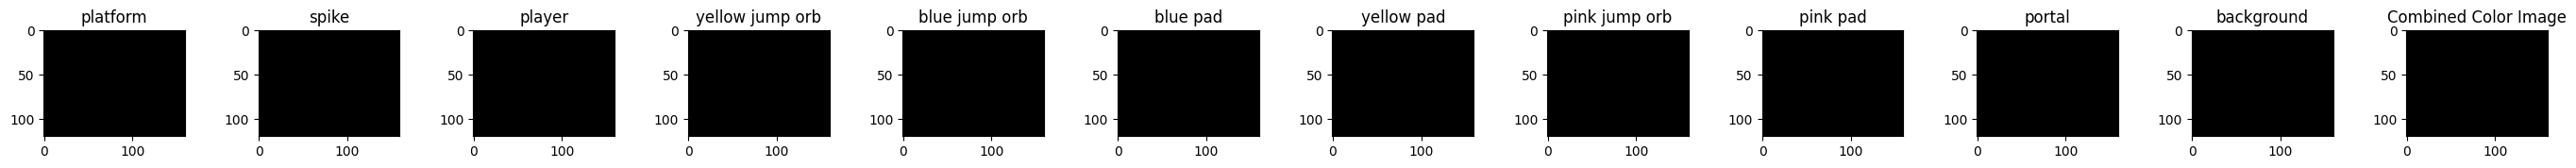

TESTING:  12 (3, 120, 160)


IndexError: index 3 is out of bounds for axis 0 with size 3

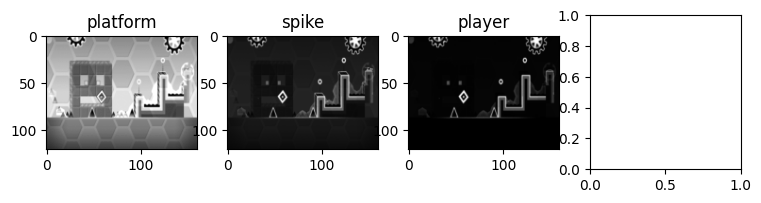

In [53]:
inputs, labels = next(iter(train_loader))
outputs = BaseMODEL(inputs)
pred = get_pred(outputs)
# print(pred, pred.shape)
CustomDataset.plot_multi_mask(labels[5])
CustomDataset.plot_multi_mask(pred[5])
CustomDataset.plot_multi_mask(inputs[5])
# print(labels, labels.shape)

In [ ]:
x = F.softmax(pred, dim=1)
max_vals, _ = torch.max(x, dim=1, keepdim=True)
binary_mask = (x == max_vals).float()
print(binary_mask, x.shape)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [ ]:
model_accuracy(BaseMODEL, test_loader)

0.0